In [1]:
import os
import cv2
import numpy as np
import skimage.io
from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
from tqdm.auto import tqdm
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
np.random.seed(0) 

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-07-06 11:24:48.661712: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


LAHE

training images directory

In [2]:
path1 = './IDRID/Original_Images/Training_Set'
# training masks directory
path2 = './IDRID/All_Segmentation_Groundtruths/Training_Set/Microaneurysms'
patch_size = 512

In [3]:
image_dataset = []
images = sorted(os.listdir(path1)) 
for i, image_name in tqdm(enumerate(images), total=len(images)):  
   if image_name.endswith(".jpg"):                   
       image = skimage.io.imread(path1+"/"+image_name)  #Read image
       image = image[:,:,1] #selecting green channel
#        image = clahe_equalized(image) #applying CLAHE
#        SIZE_X = (image.shape[1]//patch_size)*patch_size #getting size multiple of patch size
#        SIZE_Y = (image.shape[0]//patch_size)*patch_size #getting size multiple of patch size
       image = Image.fromarray(image)        
       image = image.resize((512, 512)) #resize image       
       image = np.array(image) 
#        patches_img = patchify(image, (patch_size, patch_size), step=patch_size)  #create patches(patch_sizexpatch_sizex1)
       image = (image.astype('float32')) / 255.                    
       image_dataset.append(image)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:15<00:00,  3.52it/s]


In [4]:
len(image_dataset)

54

In [5]:
np.min(image_dataset)

0.0

In [6]:
np.max(image_dataset)

1.0

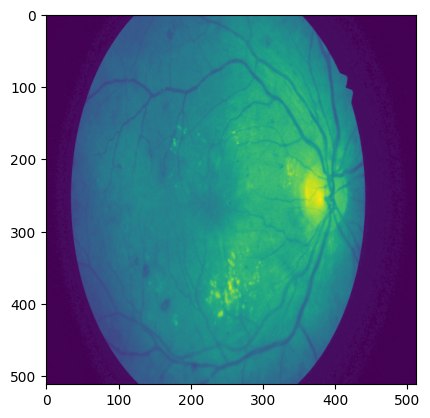

In [7]:
plt.imshow(image_dataset[0])

In [8]:
mask_dataset = []
images = sorted(os.listdir(path2)) 

for i, image_name in tqdm(enumerate(images), total=len(images)):
    if image_name.endswith(".tif"):
        image = skimage.io.imread(path2 + "/" + image_name)  # Read image

        if image.ndim == 3:  # RGB image
            image = image[:, :, 1]  # Select green channel
        # else:  # Grayscale or single-channel image, no need to select channel

        image = Image.fromarray(image)
        image = image.resize((512, 512))  # Resize image to 512x512
        image = np.array(image, dtype=np.float32)  # Convert to float32 and normalize

        mask_dataset.append(image)
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)
image_dataset = np.expand_dims(image_dataset,axis=-1)
mask_dataset =  np.expand_dims(mask_dataset,axis=-1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:02<00:00, 21.61it/s]


In [9]:
len(mask_dataset)

54

In [10]:
mask_dataset[0].shape

(512, 512, 1)

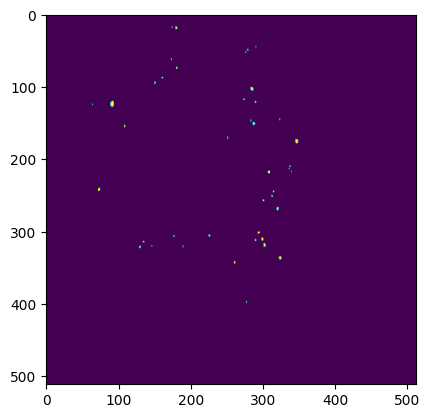

In [11]:
plt.imshow(mask_dataset[34])

In [12]:
np.min(mask_dataset)

0.0

In [13]:
np.max(mask_dataset)

1.0

mporting models

In [14]:
from model import unetmodel, residualunet, attentionunet
from tensorflow.keras.optimizers import Adam
from evaluation_metrics import IoU_coef,IoU_loss
import tensorflow as tf

In [15]:
IMG_HEIGHT = 512
IMG_WIDTH = 512
IMG_CHANNELS = 1
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [16]:
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K


def conv_block(x, kernelsize, filters, dropout, batchnorm=False):
    conv = layers.Conv2D(filters, (kernelsize, kernelsize),
                         kernel_initializer='he_normal', padding="same")(x)
    if batchnorm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)
    conv = layers.Conv2D(filters, (kernelsize, kernelsize),
                         kernel_initializer='he_normal', padding="same")(conv)
    if batchnorm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    return conv


def inverted_residual_block(x, expand=64, squeeze=16, dropout=0, batchnorm=False):
    m = layers.Conv2D(expand, (1, 1), activation='relu')(x)
    if batchnorm is True:
        m = layers.BatchNormalization(axis=3)(m)
    m = layers.DepthwiseConv2D((3, 3), activation='relu', padding='same')(m)
    if batchnorm is True:
        m = layers.BatchNormalization(axis=3)(m)
    m = layers.Conv2D(squeeze, (1, 1), activation='relu')(m)
    if dropout > 0:
        m = layers.Dropout(dropout)(m)
    if x.shape[-1] != squeeze:
        x = layers.Conv2D(squeeze, (1, 1), activation='relu')(x)
    respath = layers.add([m, x])
    return respath

# residual convolutional block


def res_conv_block(x, kernelsize, filters, dropout, batchnorm=False):
    conv1 = layers.Conv2D(filters, (kernelsize, kernelsize),
                          kernel_initializer='he_normal', padding='same')(x)
    if batchnorm is True:
        conv1 = layers.BatchNormalization(axis=3)(conv1)
    conv1 = layers.Activation('relu')(conv1)
    conv2 = layers.Conv2D(filters, (kernelsize, kernelsize),
                          kernel_initializer='he_normal', padding='same')(conv1)
    if batchnorm is True:
        conv2 = layers.BatchNormalization(axis=3)(conv2)
        conv2 = layers.Activation("relu")(conv2)
    if dropout > 0:
        conv2 = layers.Dropout(dropout)(conv2)

    # skip connection
    shortcut = layers.Conv2D(filters, kernel_size=(
        1, 1), kernel_initializer='he_normal', padding='same')(x)
    if batchnorm is True:
        shortcut = layers.BatchNormalization(axis=3)(shortcut)
    shortcut = layers.Activation("relu")(shortcut)
    respath = layers.add([shortcut, conv2])
    return respath

# gating signal for attention unit


def gatingsignal(input, out_size, batchnorm=False):
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batchnorm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

# attention unit/block based on soft attention


def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(
        2, 2), kernel_initializer='he_normal', padding='same')(x)
    shape_theta_x = K.int_shape(theta_x)
    phi_g = layers.Conv2D(
        inter_shape, (1, 1), kernel_initializer='he_normal', padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3), strides=(
        shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]), kernel_initializer='he_normal', padding='same')(phi_g)
    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(
        1, (1, 1), kernel_initializer='he_normal', padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(
        shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)
    upsample_psi = layers.Lambda(lambda x, repnum: K.repeat_elements(
        x, repnum, axis=3), arguments={'repnum': shape_x[3]})(upsample_psi)
    y = layers.multiply([upsample_psi, x])
    result = layers.Conv2D(
        shape_x[3], (1, 1), kernel_initializer='he_normal', padding='same')(y)
    attenblock = layers.BatchNormalization()(result)
    return attenblock


def receptive_field_block(x, kernelsize, filters, dropout, batchnorm=False):
    conv = layers.Conv2D(filters, (kernelsize, kernelsize),
                         kernel_initializer='he_normal', padding="same")(x)
    if batchnorm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)
    conv = layers.Conv2D(filters, (kernelsize, kernelsize),
                         kernel_initializer='he_normal', padding="same")(conv)
    if batchnorm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    # Receptive field block
    pool = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    receptive_field = conv_block(pool, kernelsize, filters, dropout, batchnorm)
    upsampled_receptive_field = layers.UpSampling2D(
        size=(2, 2))(receptive_field)
    conv = layers.concatenate([conv, upsampled_receptive_field], axis=3)

    return conv


def unetmodel_residual(input_shape, dropout=0.2, batchnorm=True):
    filters = [16, 32, 64, 128, 256]
    kernelsize = 3
    upsample_size = 2

    inputs = layers.Input(input_shape)

    # Downsampling layers with receptive field blocks
    dn_1 = receptive_field_block(
        inputs, kernelsize, filters[0], dropout, batchnorm)
    pool_1 = layers.MaxPooling2D(pool_size=(2, 2))(dn_1)

    dn_2 = receptive_field_block(
        pool_1, kernelsize, filters[1], dropout, batchnorm)
    pool_2 = layers.MaxPooling2D(pool_size=(2, 2))(dn_2)

    dn_3 = receptive_field_block(
        pool_2, kernelsize, filters[2], dropout, batchnorm)
    pool_3 = layers.MaxPooling2D(pool_size=(2, 2))(dn_3)

    dn_4 = receptive_field_block(
        pool_3, kernelsize, filters[3], dropout, batchnorm)
    pool_4 = layers.MaxPooling2D(pool_size=(2, 2))(dn_4)

    dn_5 = receptive_field_block(
        pool_4, kernelsize, filters[4], dropout, batchnorm)

    # Upsampling layers
    up_5 = layers.UpSampling2D(
        size=(upsample_size, upsample_size), interpolation='bilinear')(dn_5)
    up_conv_5 = inverted_residual_block(
        up_5, expand=filters[3], squeeze=filters[3], dropout=dropout, batchnorm=batchnorm)
    up_5 = layers.concatenate([up_conv_5, dn_4], axis=3)
    up_5 = layers.Conv2D(filters[0], (kernelsize, kernelsize),
                         kernel_initializer='he_normal', padding="same")(up_5)

    up_4 = layers.UpSampling2D(
        size=(upsample_size, upsample_size), interpolation='bilinear')(up_conv_5)
    up_conv_4 = inverted_residual_block(
        up_4, expand=filters[2], squeeze=filters[2], dropout=dropout, batchnorm=batchnorm)
    up_4 = layers.concatenate([up_conv_4, dn_3], axis=3)
    up_4 = layers.Conv2D(filters[1], (kernelsize, kernelsize),
                         kernel_initializer='he_normal', padding="same")(up_4)

    up_3 = layers.UpSampling2D(
        size=(upsample_size, upsample_size), interpolation='bilinear')(up_conv_4)
    up_conv_3 = inverted_residual_block(
        up_3, expand=filters[1], squeeze=filters[1], dropout=dropout, batchnorm=batchnorm)
    up_3 = layers.concatenate([up_conv_3, dn_2], axis=3)
    up_3 = layers.Conv2D(filters[2], (kernelsize, kernelsize),
                         kernel_initializer='he_normal', padding="same")(up_3)

    up_2 = layers.UpSampling2D(
        size=(upsample_size, upsample_size), interpolation='bilinear')(up_conv_3)
    up_conv_2 = inverted_residual_block(
        up_2, expand=filters[0], squeeze=filters[0], dropout=dropout, batchnorm=batchnorm)
    up_2 = layers.concatenate([up_conv_2, dn_1], axis=3)
    up_2 = layers.Conv2D(filters[3], (kernelsize, kernelsize),
                         kernel_initializer='he_normal', padding="same")(up_2)

    conv_final = layers.Conv2D(
        1, kernel_size=(1, 1), padding='same')(up_conv_2)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    outputs = layers.Activation('sigmoid')(conv_final)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    model.summary()
    return model


In [17]:
from keras import backend as K
import tensorflow as tf

def dice_coefficient(y_true, y_pred, smooth=1e-7):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice

def dice_coefficient_loss(y_true, y_pred, smooth=1e-7):
     dc=dice_coefficient(y_true,y_pred)
     return (1-dc)

defined_metrics = [
    tf.keras.metrics.AUC(name='auc'),
#     dice_coefficient,
]

2023-07-06 11:25:10.915296: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 11:25:11.305855: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1637] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1133 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:47:00.0, compute capability: 8.0


In [18]:
model = unetmodel_residual(input_shape)
model.compile(optimizer = Adam(lr = 1e-3), loss= 'BinaryCrossentropy', metrics=defined_metrics)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

                                                                                                  
 dropout_3 (Dropout)            (None, 64, 64, 128)  0           ['activation_6[0][0]']           
                                                                                                  
 conv2d_7 (Conv2D)              (None, 64, 64, 128)  147584      ['dropout_3[0][0]']              
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 64, 64, 128)  512        ['conv2d_7[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_7 (Activation)      (None, 64, 64, 128)  0           ['batch_normalization_7[0][0]']  
                                                                                                  
 max_pooli

 batch_normalization_14 (BatchN  (None, 256, 256, 32  128        ['conv2d_18[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 depthwise_conv2d_2 (DepthwiseC  (None, 256, 256, 32  320        ['batch_normalization_14[0][0]'] 
 onv2D)                         )                                                                 
                                                                                                  
 batch_normalization_15 (BatchN  (None, 256, 256, 32  128        ['depthwise_conv2d_2[0][0]']     
 ormalization)                  )                                                                 
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 32  1056        ['batch_normalization_15[0][0]'] 
          

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


odel = residualunet(input_shape)<br>
odel.compile(optimizer = Adam(lr = 1e-3), loss= IoU_loss, metrics= ['accuracy', IoU_coef])<br>
odel = attentionunet(input_shape)<br>
odel.compile(optimizer = Adam(lr = 1e-3), loss= IoU_loss, metrics= ['accuracy', IoU_coef])<br>
odel = attention_residualunet(input_shape)<br>
odel.compile(optimizer = Adam(lr = 1e-3), loss= IoU_loss, metrics= ['accuracy', IoU_coef])

plitting data into 70-30 ratio to validate training performance

In [19]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size=0.3, random_state=0)

In [20]:
# earlyStopping = EarlyStopping(monitor='val_auc', patience=5, verbose=0, mode='max')
# mcp_save = ModelCheckpoint('./MA_models/MA_unetmodel.hdf5', save_best_only=True, monitor='val_auc', mode='max',verbose=1)
# reduce_lr_loss = ReduceLROnPlateau(monitor='val_auc', factor=0.1, patience=5, verbose=1, min_delta=1e-4, mode='max')

rain model

In [21]:
history = model.fit(x_train, y_train, 
                    verbose=1,
                    batch_size = 1,
                    validation_data=(x_test, y_test ), 
                    shuffle=False,
                    epochs=500,)
#                     callbacks=[earlyStopping, mcp_save, reduce_lr_loss])

Epoch 1/500


2023-07-06 11:25:15.967682: I tensorflow/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8700


37/37 [==============================] - 6s 53ms/step - loss: 0.7132 - auc: 0.4965 - val_loss: 0.7539 - val_auc: 0.4101
Epoch 2/500
 4/37 [==>...........................] - ETA: 0s - loss: 0.6845 - auc: 0.5846

2023-07-06 11:25:18.588951: I tensorflow/stream_executor/cuda/cuda_blas.cc:1633] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


37/37 [==============================] - 1s 24ms/step - loss: 0.6772 - auc: 0.5050 - val_loss: 0.6995 - val_auc: 0.3768
Epoch 3/500
37/37 [==============================] - 1s 25ms/step - loss: 0.6569 - auc: 0.4913 - val_loss: 0.6472 - val_auc: 0.4786
Epoch 4/500
37/37 [==============================] - 1s 23ms/step - loss: 0.6388 - auc: 0.5084 - val_loss: 0.6273 - val_auc: 0.5107
Epoch 5/500
37/37 [==============================] - 1s 22ms/step - loss: 0.6196 - auc: 0.4816 - val_loss: 0.6087 - val_auc: 0.4743
Epoch 6/500
37/37 [==============================] - 1s 22ms/step - loss: 0.6036 - auc: 0.4742 - val_loss: 0.5908 - val_auc: 0.4629
Epoch 7/500
37/37 [==============================] - 1s 23ms/step - loss: 0.5876 - auc: 0.4402 - val_loss: 0.5766 - val_auc: 0.5392
Epoch 8/500
37/37 [==============================] - 1s 21ms/step - loss: 0.5713 - auc: 0.4611 - val_loss: 0.5596 - val_auc: 0.4990
Epoch 9/500
37/37 [==============================] - 1s 24ms/step - loss: 0.5563 - auc: 

Epoch 64/500
37/37 [==============================] - 1s 20ms/step - loss: 0.1553 - auc: 0.5107 - val_loss: 0.1556 - val_auc: 0.5000
Epoch 65/500
37/37 [==============================] - 1s 23ms/step - loss: 0.1522 - auc: 0.4861 - val_loss: 0.1609 - val_auc: 0.5652
Epoch 66/500
37/37 [==============================] - 1s 25ms/step - loss: 0.1493 - auc: 0.5229 - val_loss: 0.1459 - val_auc: 0.5000
Epoch 67/500
37/37 [==============================] - 1s 28ms/step - loss: 0.1463 - auc: 0.4869 - val_loss: 0.1445 - val_auc: 0.5000
Epoch 68/500
37/37 [==============================] - 1s 26ms/step - loss: 0.1434 - auc: 0.5227 - val_loss: 0.1425 - val_auc: 0.5854
Epoch 69/500
37/37 [==============================] - 1s 23ms/step - loss: 0.1406 - auc: 0.4982 - val_loss: 0.1401 - val_auc: 0.5000
Epoch 70/500
37/37 [==============================] - 1s 21ms/step - loss: 0.1379 - auc: 0.5178 - val_loss: 0.1374 - val_auc: 0.5009
Epoch 71/500
37/37 [==============================] - 1s 21ms/step - 

37/37 [==============================] - 1s 24ms/step - loss: 0.0226 - auc: 0.5058 - val_loss: 0.0227 - val_auc: 0.5000
Epoch 187/500
37/37 [==============================] - 1s 21ms/step - loss: 0.0223 - auc: 0.5016 - val_loss: 0.0226 - val_auc: 0.5000
Epoch 188/500
37/37 [==============================] - 1s 20ms/step - loss: 0.0220 - auc: 0.5016 - val_loss: 0.0221 - val_auc: 0.5000
Epoch 189/500
37/37 [==============================] - 1s 20ms/step - loss: 0.0218 - auc: 0.5020 - val_loss: 0.0219 - val_auc: 0.5002
Epoch 190/500
37/37 [==============================] - 1s 23ms/step - loss: 0.0215 - auc: 0.5023 - val_loss: 0.0224 - val_auc: 0.5000
Epoch 191/500
37/37 [==============================] - 1s 28ms/step - loss: 0.0213 - auc: 0.5078 - val_loss: 0.0223 - val_auc: 0.5001
Epoch 192/500
37/37 [==============================] - 1s 30ms/step - loss: 0.0210 - auc: 0.5154 - val_loss: 0.0203 - val_auc: 0.5164
Epoch 193/500
37/37 [==============================] - 1s 20ms/step - loss: 

37/37 [==============================] - 1s 20ms/step - loss: 0.0074 - auc: 0.8869 - val_loss: 0.0098 - val_auc: 0.5031
Epoch 309/500
37/37 [==============================] - 1s 26ms/step - loss: 0.0072 - auc: 0.8874 - val_loss: 0.0093 - val_auc: 0.5012
Epoch 310/500
37/37 [==============================] - 1s 28ms/step - loss: 0.0072 - auc: 0.8900 - val_loss: 0.0090 - val_auc: 0.5038
Epoch 311/500
37/37 [==============================] - 1s 26ms/step - loss: 0.0071 - auc: 0.8878 - val_loss: 0.0092 - val_auc: 0.5044
Epoch 312/500
37/37 [==============================] - 1s 24ms/step - loss: 0.0070 - auc: 0.8935 - val_loss: 0.0095 - val_auc: 0.5025
Epoch 313/500
37/37 [==============================] - 1s 22ms/step - loss: 0.0069 - auc: 0.8952 - val_loss: 0.0091 - val_auc: 0.5049
Epoch 314/500
37/37 [==============================] - 1s 19ms/step - loss: 0.0068 - auc: 0.8897 - val_loss: 0.0099 - val_auc: 0.4939
Epoch 315/500
37/37 [==============================] - 1s 23ms/step - loss: 

37/37 [==============================] - 1s 20ms/step - loss: 0.0027 - auc: 0.9758 - val_loss: 0.0134 - val_auc: 0.5000
Epoch 431/500
37/37 [==============================] - 1s 24ms/step - loss: 0.0027 - auc: 0.9733 - val_loss: 0.0127 - val_auc: 0.5002
Epoch 432/500
37/37 [==============================] - 1s 24ms/step - loss: 0.0026 - auc: 0.9785 - val_loss: 0.0101 - val_auc: 0.5035
Epoch 433/500
37/37 [==============================] - 1s 25ms/step - loss: 0.0027 - auc: 0.9734 - val_loss: 0.0249 - val_auc: 0.5000
Epoch 434/500
37/37 [==============================] - 1s 25ms/step - loss: 0.0026 - auc: 0.9771 - val_loss: 0.0108 - val_auc: 0.5029
Epoch 435/500
37/37 [==============================] - 1s 20ms/step - loss: 0.0027 - auc: 0.9755 - val_loss: 0.0109 - val_auc: 0.5019
Epoch 436/500
37/37 [==============================] - 1s 23ms/step - loss: 0.0026 - auc: 0.9767 - val_loss: 0.0160 - val_auc: 0.5000
Epoch 437/500
37/37 [==============================] - 1s 23ms/step - loss: 

raining-validation loss curve

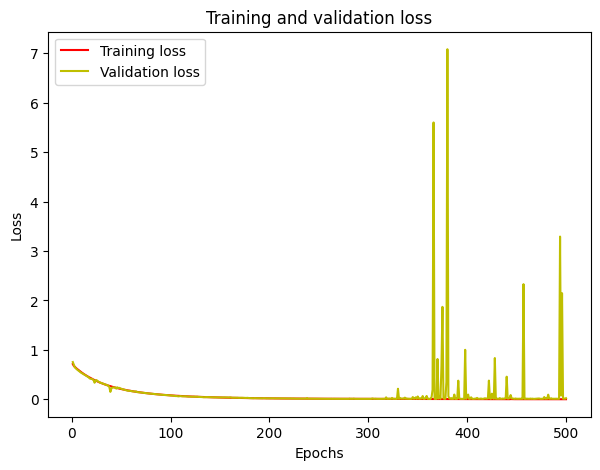

In [22]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(7,5))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

raining-validation accuracy curve

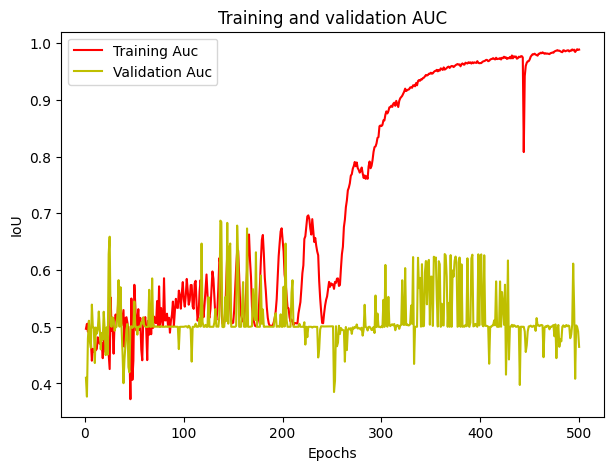

In [23]:
auc = history.history['auc']
val_auc = history.history['val_auc']
plt.figure(figsize=(7,5))
plt.plot(epochs, auc, 'r', label='Training Auc')
plt.plot(epochs, val_auc, 'y', label='Validation Auc')
plt.title('Training and validation AUC')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

raining-validation IoU curve

In [25]:
model.save('./MA_models/Microaneurysms_unetmodel_ive.h5')

In [26]:
model = tf.keras.models.load_model('./MA_models/Microaneurysms_unetmodel_ive.h5', custom_objects={'dice_coefficient_loss': dice_coefficient_loss})

In [27]:
# test dataset images directory path
path3 = './IDRID/Original_Images/Testing_Set'
# test dataset mask directory path
path4 = './IDRID/All_Segmentation_Groundtruths/Testing_Set/Microaneurysms'

In [28]:
testimages = sorted(os.listdir(path3))
testmasks =  sorted(os.listdir(path4))

In [29]:
import os
import cv2
import numpy as np
import skimage.io
from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
from tqdm.auto import tqdm
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
np.random.seed(0)

image_dataset = []
images = sorted(os.listdir(path3)) 
for i, image_name in tqdm(enumerate(images), total=len(images)):  
   if image_name.endswith(".jpg"):                   
       image = skimage.io.imread(path3+"/"+image_name)  #Read image
       image = image[:,:,1] #selecting green channel
#        image = clahe_equalized(image) #applying CLAHE
#        SIZE_X = (image.shape[1]//patch_size)*patch_size #getting size multiple of patch size
#        SIZE_Y = (image.shape[0]//patch_size)*patch_size #getting size multiple of patch size
       image = Image.fromarray(image)        
       image = image.resize((512, 512)) #resize image       
       image = np.array(image) 
#        patches_img = patchify(image, (patch_size, patch_size), step=patch_size)  #create patches(patch_sizexpatch_sizex1)
       image = (image.astype('float32')) / 255.                    
       image_dataset.append(image)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:07<00:00,  3.68it/s]


In [30]:
mask_dataset = []
images = sorted(os.listdir(path4)) 

for i, image_name in tqdm(enumerate(images), total=len(images)):
    if image_name.endswith(".tif"):
        image = skimage.io.imread(path4 + "/" + image_name)  # Read image

        if image.ndim == 3:  # RGB image
            image = image[:, :, 1]  # Select green channel
        # else:  # Grayscale or single-channel image, no need to select channel

        image = Image.fromarray(image)
        image = image.resize((512, 512))  # Resize image to 512x512
        image = np.array(image, dtype=np.float32)  # Convert to float32 and normalize

        mask_dataset.append(image)
 
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)
test_image_dataset = np.expand_dims(image_dataset,axis=-1)
test_mask_dataset =  np.expand_dims(mask_dataset,axis=-1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:01<00:00, 16.66it/s]


In [31]:
np.min(test_mask_dataset)

0.0

In [32]:
np.max(test_mask_dataset)

1.0

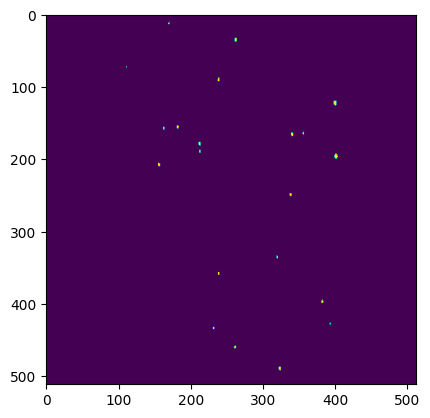

In [33]:
plt.imshow(test_mask_dataset[1])

In [34]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_image_dataset, test_mask_dataset, batch_size=1)
print("test loss, test auc:", results)

Evaluate on test data
27/27 [==============================] - 1s 9ms/step - loss: 0.0210 - auc: 0.4696
test loss, test auc: [0.021001650020480156, 0.4696369767189026]


In [35]:
val_pred = model.predict(test_image_dataset,batch_size=1)

27/27 [==============================] - 1s 5ms/step


In [36]:
np.min(val_pred)

2.9344887e-17

In [37]:
np.max(val_pred)

0.9837821

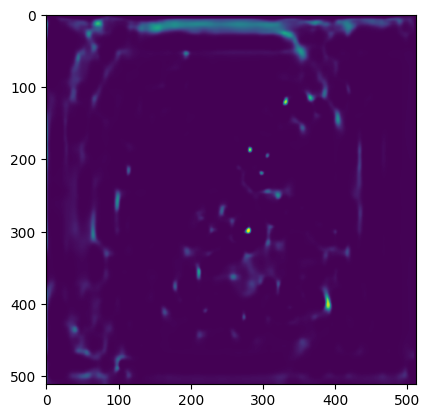

In [40]:
plt.imshow(val_pred[24])
# np.argmax(val_pred,axis=0)

In [39]:
for i in range (val_pred.shape[0]) :
    print(i,np.sum(val_pred[i,:,:,:]))

0 3573.3386
1 3802.6892
2 3460.9644
3 3072.9607
4 3858.6987
5 3709.5862
6 3860.0696
7 4353.372
8 2400.6152
9 2933.953
10 4183.869
11 4375.188
12 2593.8477
13 3682.5771
14 2607.9507
15 3630.6357
16 4213.7617
17 2846.8513
18 3778.2544
19 3963.6697
20 3504.907
21 4237.9097
22 3863.8374
23 3045.7073
24 5151.013
25 3506.1414
26 3824.6677
